<div style="width: 100%; clear: both;">
    <div style="float: left; width: 50%;">
        <img src="../figs/uoc_masterbrand_3linies_positiu.png", align="left">
    </div>
    <div style="float: right; width: 50%;">
        <p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades</p>
        <p style="margin: 0; text-align:right;">Màster universitari en Ciència de dades (<i>Data science</i>)</p>
        <p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'informàtica, multimèdia i telecomunicació</p>
    </div>
</div>
<div style="width:100%;">&nbsp;</div>

# Exemple d'anàlisi de sèries temporals (TSA)

En aquest exemple treballarem amb xarxes neuronals recurrents en un problema de regressió amb dades generades sintèticament, a partir de la llibreria `Keras`.

A l'inici de l'exemple veurem com generar dades de manera sintètica per a una sèrie temporal. A continuació, intentarem eliminar tendències i estacionalitats per preparar les dades i, finalment, amb les dades normalitzades, entrenarem diversos models que permetran predir els valors futurs de la sèrie.

# 1. Càrrega de les llibreries

El codi següent carrega els paquets necessaris per a aquest exemple.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# 2. Generació de les dades sintètiques

En aquest exemple treballem amb una sèrie temporal generada sintèticament utilitzant `numpy`. 

El codi següent genera una sèrie temporal amb certa aleatorietat, guarda la sèrie a la variable `serie` i la visualitza en un gràfic.

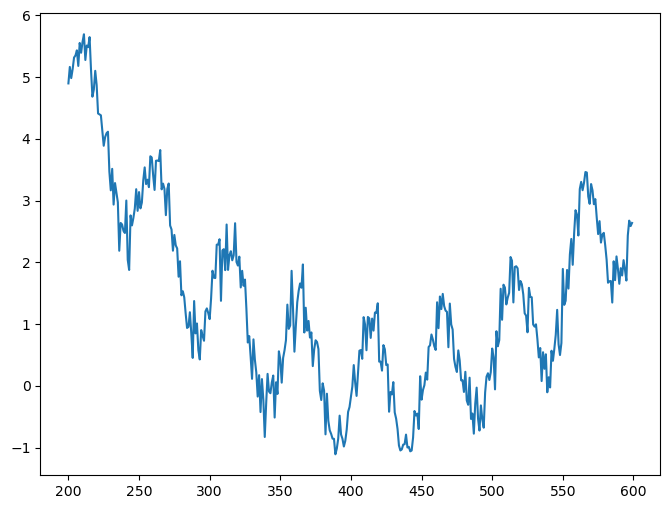

In [2]:
# funció per generar les dades de la sèrie
def f(x):
    return np.square(-x + 425) / 10000 + np.sin(x / 8) + 0.25 * np.random.randn()


# dades de la sèrie
idx = np.arange(200, 600)
serie = [f(x) for x in idx]

# visualització de la sèrie
plt.rc("figure", figsize=(8, 6))
plt.plot(idx, serie)
plt.show()

# 3. Eliminar la tendència i l'estacionalitat

Perquè la xarxa neuronal pugui extreure patrons de la sèrie temporal cal transformar la sèrie perquè els valors estiguin sempre al mateix rang. Per això, podem extreure la **tendència** i l'**estacionalitat** de la sèrie i desfer el canvi a l'hora d'obtenir prediccions.

En aquest cas d'exemple, en haver generat les dades de forma sintètica, podem calcular la periodicitat exacta mitjançant la fórmula de generació de dades. Atès que el sinus és una funció periòdica de període $2*\pi$, el període de la sèrie serà aquell valor de $x$ tal que $x$ / 8 = $2*\pi$, que, arrodonit a un nombre enter, és 50.

A continuació, extraurem la tendència i l'estacionalitat de forma empírica per dibuixar-la amb el mètode `plot`.

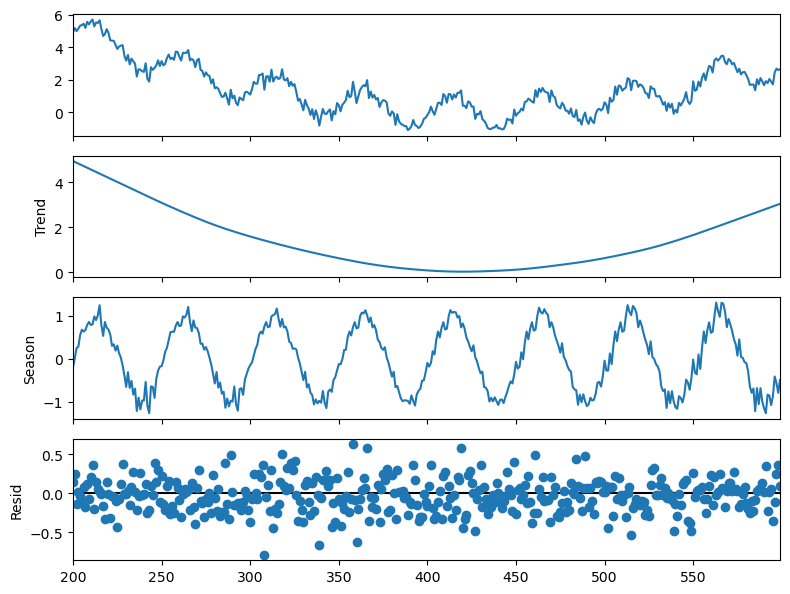

In [3]:
# descomposició de la sèrie (convertir a Series de pandas)
serie_pd = pd.Series(serie, index=idx)
result = STL(serie_pd, seasonal=51, trend=101, period=50).fit()
result.plot()
plt.show()

A continuació, repetirem l'extracció de tendència i estacionalitat utilitzant diferents valors per al període, per tal de veure la rellevància de determinar el període en l'extracció de la tendència i l'estacionalitat. Provarem amb valors múltiples i divisors del període, així com altres valors a l'atzar.

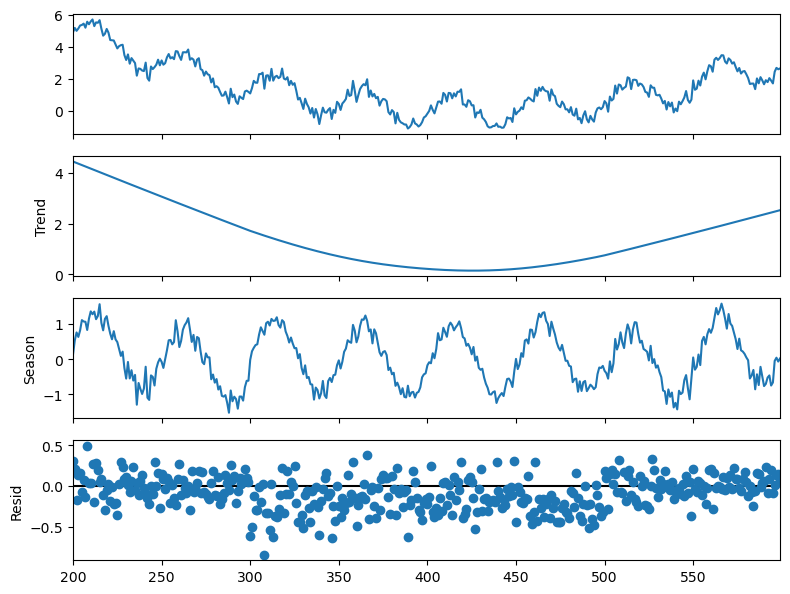

In [4]:
# descomposició de la sèrie amb període=100
result_100 = STL(serie_pd, seasonal=101, trend=201, period=100).fit()
result_100.plot()
plt.show()

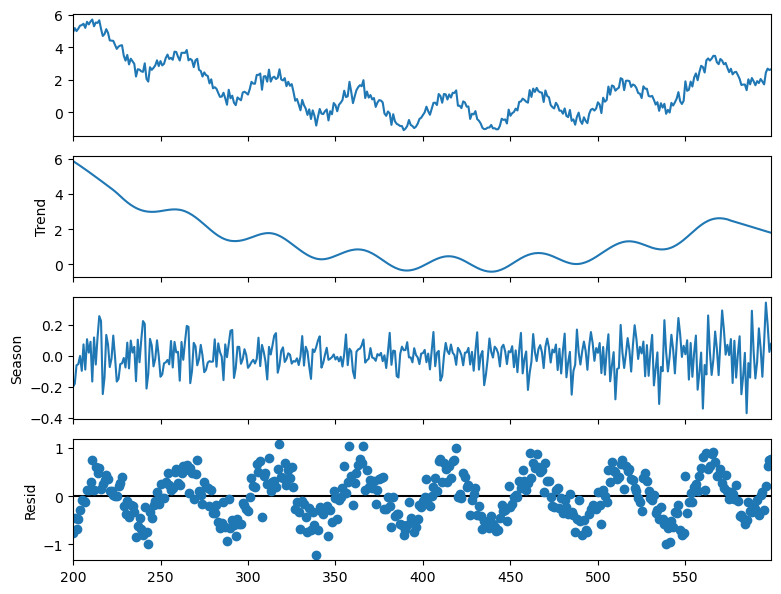

In [5]:
# descomposició de la sèrie amb període=25
result_25 = STL(serie_pd, seasonal=25, trend=51, period=25).fit()
result_25.plot()
plt.show()

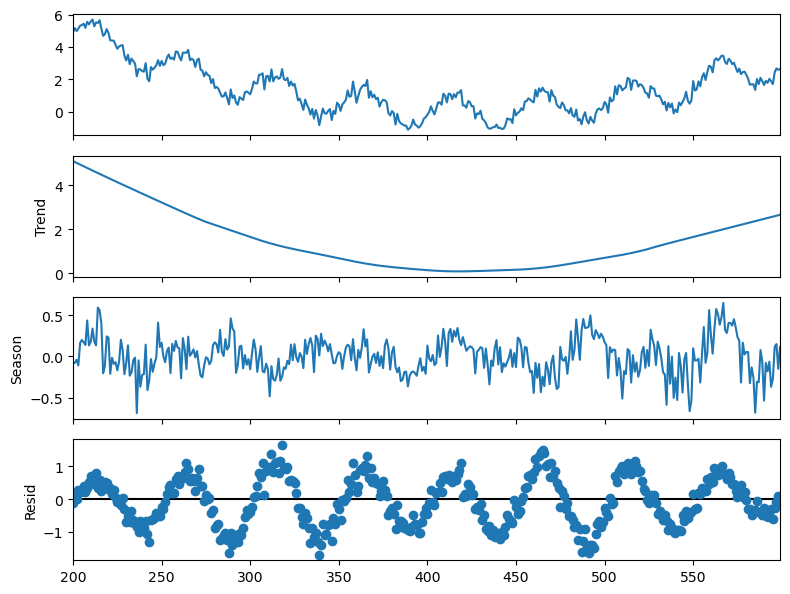

In [6]:
# descomposició de la sèrie amb període=75
result_75 = STL(serie_pd, seasonal=75, trend=151, period=75).fit()
result_75.plot()
plt.show()

A partir dels exemples anteriors i la importància de calcular correctament el període estacional d'una sèrie temporal,podem determinar que:

- Si s'utilitza un **múltiple del període correcte**, la descomposició es fa bé.
- Si s'utilitzen **altres valors**, la descomposició perd completament el sentit.

Hi ha molts altres mètodes per eliminar la tendència i l'estacionalitat d'una sèrie.

Una possibilitat consisteix a transformar la sèrie fent $y[t] = x[t] - x[t-1]$. En aquest cas, les diferències principals amb l'exemple vist són:

- Es pot fer servir en qualsevol cas i no cal esbrinar el període d'estacionalitat.
- Es perd la "memòria" de la xarxa, ja que el valor $y[t]$ només depèn dels valors de la sèrie en $t-1$ i $t$.

# 4. Predicció de la tendència

La tendència d'una sèrie temporal canvia lentament amb el temps. A més, en el moment de fer prediccions normalment pren valors fora del rang que apareix a les dades d'entrenament. Això força el model a extrapolar, per la qual cosa cal utilitzar models molt robustos per predir la tendència.

En primer lloc, entrenarem un model polinomial amb les variables $x$ i $x^2$ per predir els valors de la tendència en el conjunt d'entrenament, utilitzant la llibreria `LinearRegression`.

In [7]:
# Preparació de les dades i entrenament del model
features = np.hstack([idx.reshape(-1, 1), np.square(idx.reshape(-1, 1))])
reg = LinearRegression().fit(features, result.trend)

Al següent fragment de codi crearem un gràfic amb la tendència original i la seva predicció.

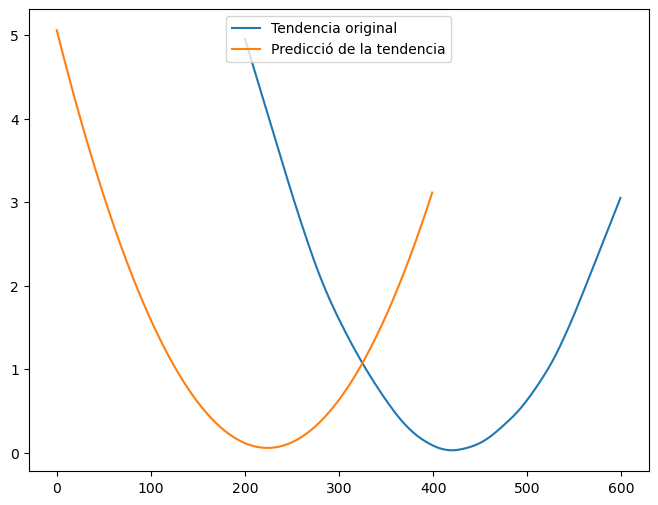

In [8]:
# Visualització de la tendència original i la predicció
plt.rc("figure", figsize=(8, 6))
plt.plot(result.trend, label="Tendencia original")
plt.plot(reg.predict(features), label="Predicció de la tendencia")
plt.legend(loc="upper center")
plt.show()